# Replaying Old Data

- Work under a separate branch with git (i.e. git checkout -b my-new-branch)

- Make a new folder in Projects (for your specific purposes)

- Copy this ipynb file that folder

- The data is stored on L-Drive

- the main gist of re-playing existing data is:
    - that your first load everything into a big matrix with mne
    - then initialize a specific **amp** (i.e., the "replayamp")
    - then do exactly the same as normal, with a while True loop with calls to amp.get_data()
    

In [1]:
# import all the needed stuff:

import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle
import dynarray

import logging
logging.basicConfig(level=logging.ERROR)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra

sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc

from scipy import signal

In [2]:
# real-time data filtering

fs=5000.
f_low = 1.0
# f_high = 15.0
butter_ord = 3
lenchannels = 64

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_hp, rt_a_hp = signal.butter(butter_ord, 2*f_low/fs, btype='high', analog=False)  # a digital high-pass filter
rt_zi_hp = proc.lfilter_zi(rt_b_hp, rt_a_hp, lenchannels)


In [3]:
fs=5000.
f_low = 12.0
f_high = 15.0
butter_ord = 3
lenchannels = 64

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
rt_b_bp, rt_a_bp = signal.butter(butter_ord, [2*f_low/fs, 2*f_high/fs], btype='band', analog=False)  # a digital high-pass filter
rt_zi_bp = proc.lfilter_zi(rt_b_bp, rt_a_bp, lenchannels)

In [4]:
# this is the replay notebook - so select a file for playback - this is for brainvision files.

fn=easygui.fileopenbox(default='/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/*.vhdr')
print(fn)

raw_fromfile = mne.io.read_raw_brainvision(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

/media/ldrive/Lab_MichaelB/Johan/nf/rawdata/T0008/eeg/ExpPre-Run01_0001_50.vhdr
Extracting parameters from /media/ldrive/Lab_MichaelB/Johan/nf/rawdata/T0008/eeg/ExpPre-Run01_0001_50.vhdr...
No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
Setting channel info structure...


<ipython-input-4-b397cd66af22>:6: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw_fromfile = mne.io.read_raw_brainvision(fn)


<RawBrainVision  |  ExpPre-Run01_0001_50.eeg, n_channels x n_times : 65 x 3405600 (681.1 sec), ~164 kB, data not loaded>

In [ ]:
# this is the replay notebook - so select a file for playback - this is for eeglab files.

fn=easygui.fileopenbox(default='*.set')
print(fn)

raw_fromfile = mne.io.read_raw_eeglab(fn)
montage=mne.channels.read_montage('standard_1005', ch_names=raw_fromfile.ch_names)  # always use MNE definitions
raw_fromfile.set_montage(montage)

In [5]:
# prepare data for replay (warning: need probably a lot of memory)

mul_factor = 1.0
if 1e-6 in [raw_fromfile.info['chs'][0]['cal'], raw_fromfile.info['chs'][0]['range']]:
    mul_factor = 1.0 / 1e-6

seed_d=raw_fromfile[:-1,:][0] * mul_factor  # scale the data to seed (so no 1e-6 stuff in the replayed data)
seed_d=np.array(seed_d.transpose())
seed_ch=raw_fromfile.ch_names[0:-1]
seed_fs=raw_fromfile.info['sfreq']

# prepare for replay; markers:
seed_mdata=np.transpose(raw_fromfile[-1,:][0])
seed_m=[[i / raw_fromfile.info['sfreq'] * 1000, int(m[0])] for i, m in enumerate(seed_mdata) if m > 0] 

In [6]:
amp = libmushu.get_amp('replayamp')
amp.configure(seed_d, seed_m, seed_ch, seed_fs, realtime=True, blocksize_samples=100)

In [7]:
alld=dynarray.DynamicArray((None, len(amp.get_channels())))     # data
allm=[]     # markers
sfreq = amp.get_sampling_frequency()  # sampling frequency
ch_names=amp.get_channels()  # channel names

markTime=time.time()
updateTime = 0.1  # run some kind of calculation every X seconds
buffSize = 1.0  # run calculation on last X seconds of data


rb = RingBuffer(buffSize * 10000)  # the buffer containing the last X seconds of data - declared in MILISECONDS
totalTime = seed_d.shape[0]/raw_fromfile.info['sfreq']

In [8]:
amp.start()

In [9]:
# l=LoopState(); l.start()
markeroffset = 0  # needed to store all data in one big mat/vector
t0=time.time()
curTime=time.time()
st=''
while curTime - t0 < totalTime:  # l.get_state() != 'Stop':
   
    
    # keep track of time:
    curTime = time.time()
    
    # this is where you get the data
    data, marker = amp.get_data()
    
    if data.shape[0] > 0:  # this is crucual for remembering filter state.

        cnt = io.convert_mushu_data(data, marker, sfreq, ch_names)

        f_cnt, rt_zi_bp = proc.lfilter(cnt, rt_b_bp, rt_a_bp, zi=rt_zi_bp)  # real-time data preprocessing...

        newsamples = cnt.data.shape[0]

        rb.append(f_cnt)

        # append it to the big matrix
        alld.extend(data)
        for m in marker:
            allm.append([m[0] + markeroffset, m[1]])
        markeroffset += newsamples / float(sfreq) * 1000.
        

        

        # do the following every 0.1 msec - with with the ringbuffer:
        if curTime - markTime > updateTime:
            # do Stuff

            markTime = curTime
            # 1) obtain last 1-second(s)
            d = rb.get()

            # thomas does stuff here


            # we send the value to BCI/STIM



            clear_output(wait=True)  # write some logging information here
            print('Playing Back - time = %f' % (curTime - t0))
            print('Length Markers: %d' % len(allm))
            print(data.shape)





Playing Back - time = 11.453466
Length Markers: 0
(100, 64)


KeyboardInterrupt: 

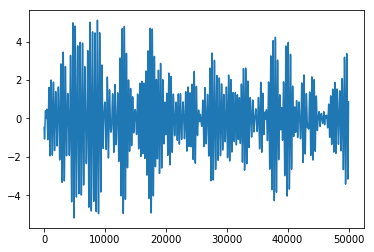

In [14]:
plt.figure()
plt.plot(rb.get().data[:,0])

In [10]:
amp.stop()
alld.shrink_to_fit()

amplifier stopped!


In [16]:
# write to disk, so we can re-load it later:

t={'alld':alld, 'allm':allm, 'ch_names':ch_names, 'sfreq':sfreq}
with open('c-allm-and-alld.pkl', 'wb') as f:
    pickle.dump(t, f)

In [2]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [ ]:
raw = convert_alld_allm_to_mne(alld, allm, ch_names, sfreq)  # covert to MNE
raw.resample(1000)

The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.


../../nftools/nftools/analysis.py:31: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  montage=montage


Creating RawArray with float64 data, n_channels=64, n_times=3405600
    Range : 0 ... 3405599 =      0.000 ...   681.120 secs
Ready.
5000.0
Creating RawArray with float64 data, n_channels=1, n_times=3405600
    Range : 0 ... 3405599 =      0.000 ...   681.120 secs
Ready.
2485 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  24  26  30
  31  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82
  83  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223
 224 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]


In [5]:
%matplotlib qt5

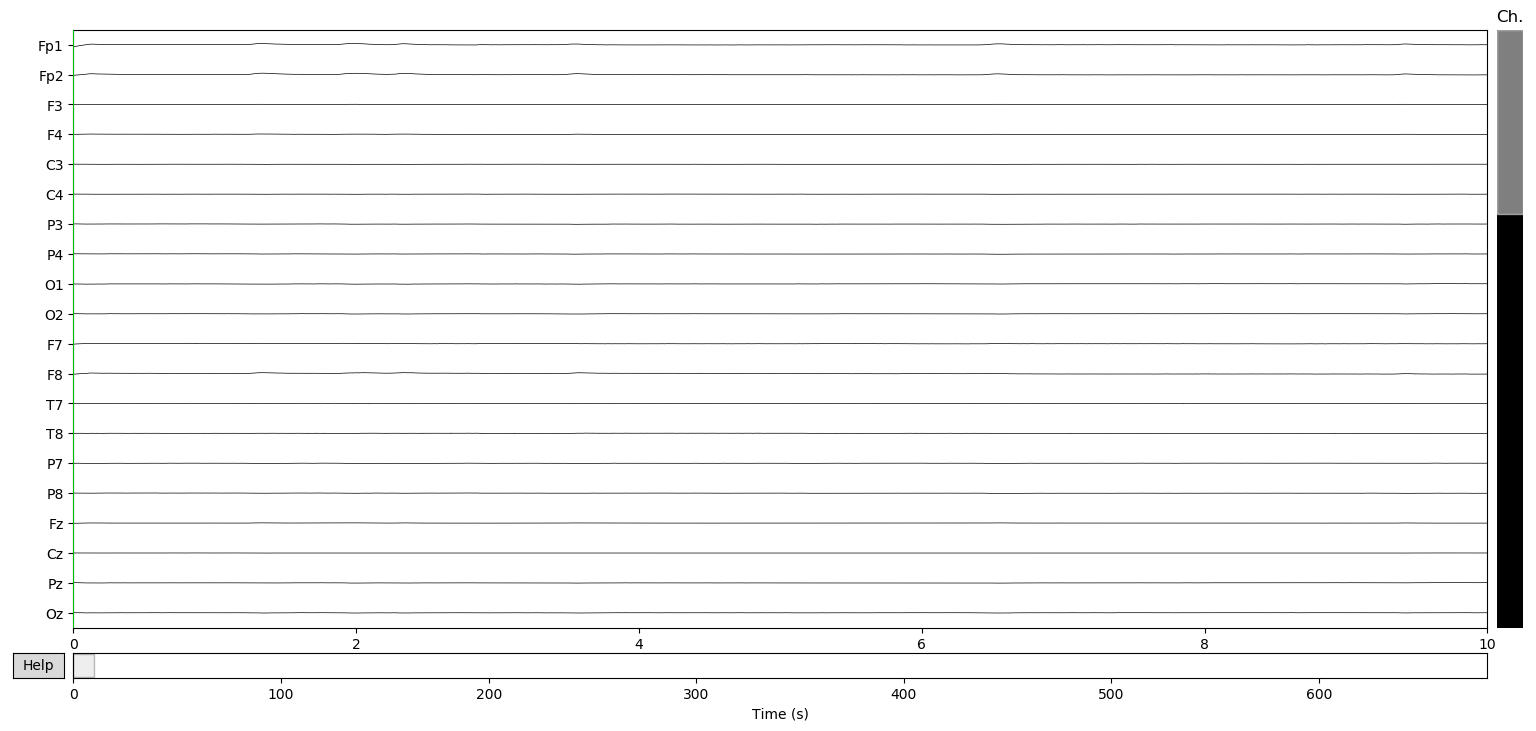

In [14]:
raw.plot(scalings='auto')

In [ ]:
# raw.set_eeg_reference(ref_channels='average')
# better not (yet) - before removing bad channels, since these mess up your data big time: see PREP paper:


In [6]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads')

raw.notch_filter(np.arange(50, 300, 50), picks=picks, filter_length='auto', phase='zero')
# add it (potentialy) some other preprocessing steps here

Setting up band-stop filter
Filter length of 6601 samples (6.601 sec) selected


<RawArray  |  None, n_channels x n_times : 65 x 681120 (681.1 sec), ~338.0 MB, data loaded>

In [7]:
# split data sets between EO and EC

newraw_eo=select_part_from_mne_dataset(raw, markers=[201, 202])
newraw_ec=select_part_from_mne_dataset(raw, markers=[203, 204])

using markers
2485 events found
Event IDs: [  1   2   3   4   5   6   7   8  11  12  13  14  15  21  23  24  26  30
  31  40  41  42  43  44  45  46  51  52  53  54  55  56  60  80  81  82
  83  84  85  86 131 132 133 134 135 136 140 201 202 203 204 221 222 223
 224 225 226 227 228 229 231 232 233 234 241 242 243 244 245 246 247]
using boundaries
[[ 5.80044227e+01  5.92983695e+01  5.96043737e+01 ... -3.72215041e+01
  -3.72645903e+01 -3.85476492e+01]
 [ 6.05508425e+01  5.96259176e+01  5.76691278e+01 ...  5.20232927e+01
   5.39751657e+01  6.00471809e+01]
 [ 7.50151298e+00  1.61515251e+01  1.60501619e+01 ...  1.02363280e+01
   1.01381830e+01  1.01107601e+01]
 ...
 [ 4.86044687e+01  4.88868140e+01  4.88352151e+01 ... -4.47123607e+00
  -3.01972583e+00 -2.11218073e-01]
 [ 1.37594489e+01  1.17380194e+01  9.88115753e+00 ... -1.57230692e+01
  -1.41664483e+01 -1.32697725e+01]
 [ 2.00967857e+02 -3.21407153e-02 -3.21387876e-02 ...  1.60716409e-02
   1.60735698e-02  1.60754987e-02]]
Creating RawArr

In [8]:
d1=plot_compare_two_spectra(newraw_eo, newraw_ec, freqs=[1, 25], n_fft=2048, n_overlap=512, chs_to_include=['Oz','O1','O2','PO8', 'PO7'], freq_lims_topoplot=[7, 12], pow_lims = [-10, 25])


Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
['Oz', 'O1', 'O2', 'PO8', 'PO7']
[8, 9, 19, 57, 58]


In [14]:
plt.figure();plt.plot(newraw_eo[0,0:1000][0].transpose())

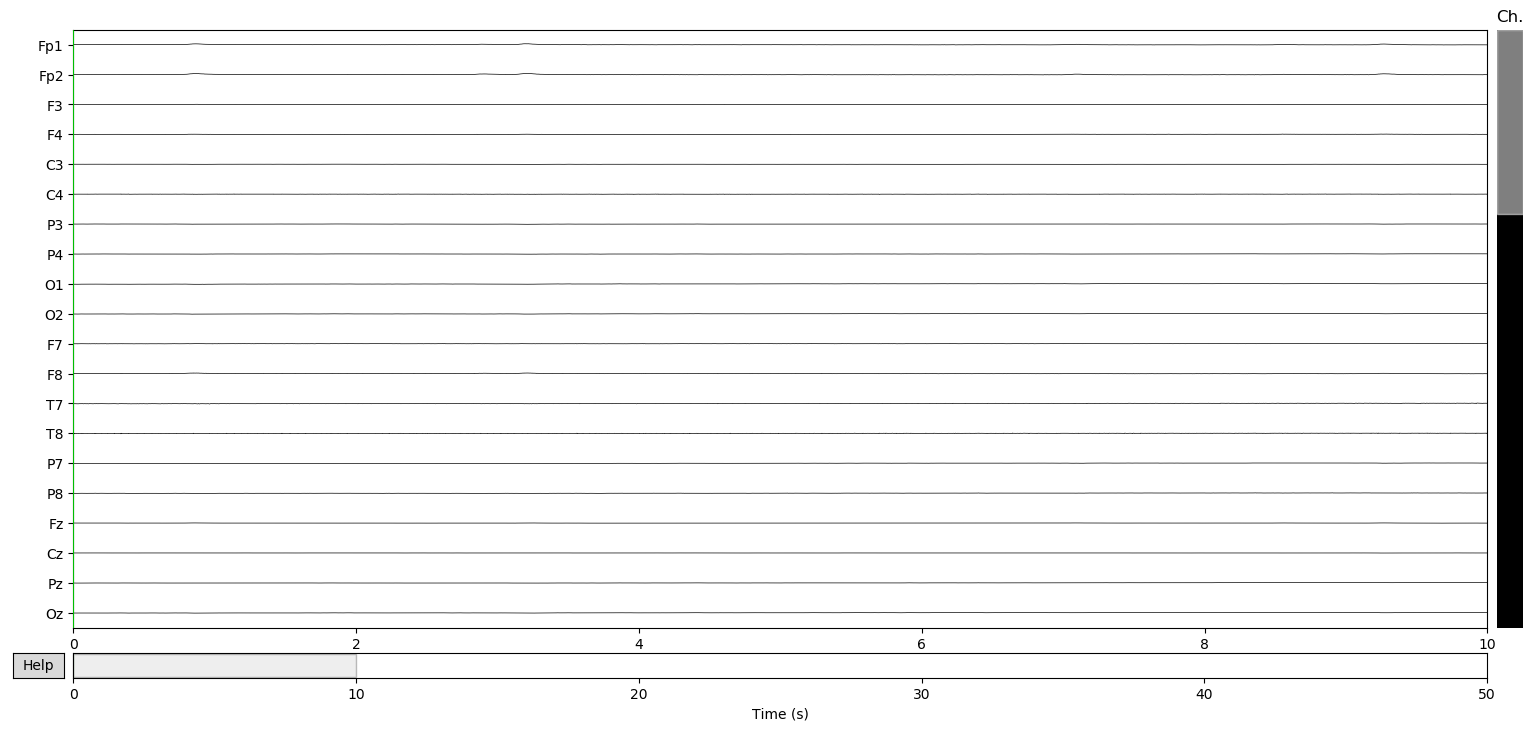

In [10]:
newraw_eo.plot(scalings='auto')

/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


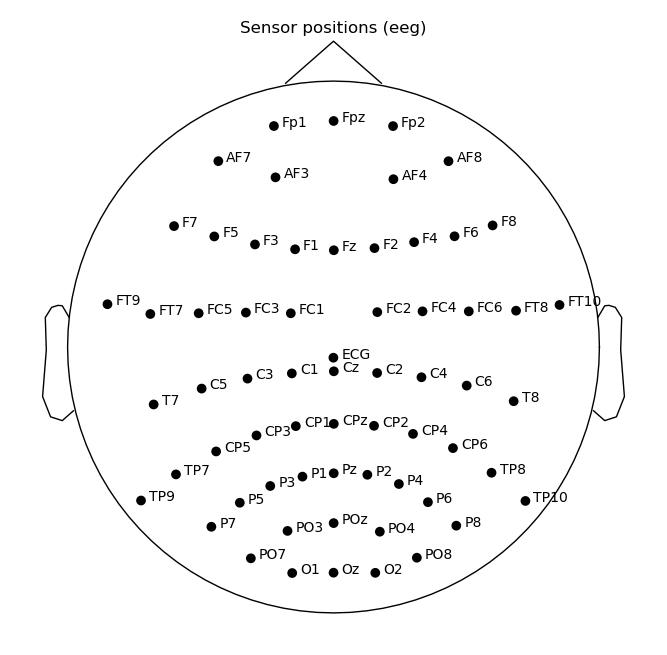

In [18]:
mne.viz.plot_sensors(newraw_ec.info, show_names=True)

In [8]:
%matplotlib qt5

Effective window size : 2.048 (s)


/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/mne/viz/evoked.py:162: RuntimeWarning: invalid value encountered in maximum
  rgb /= np.maximum(rgb.max(0), 1e-16)  # avoid div by zero
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/johan/.conda/envs/rt/lib/python3.6/site-packag

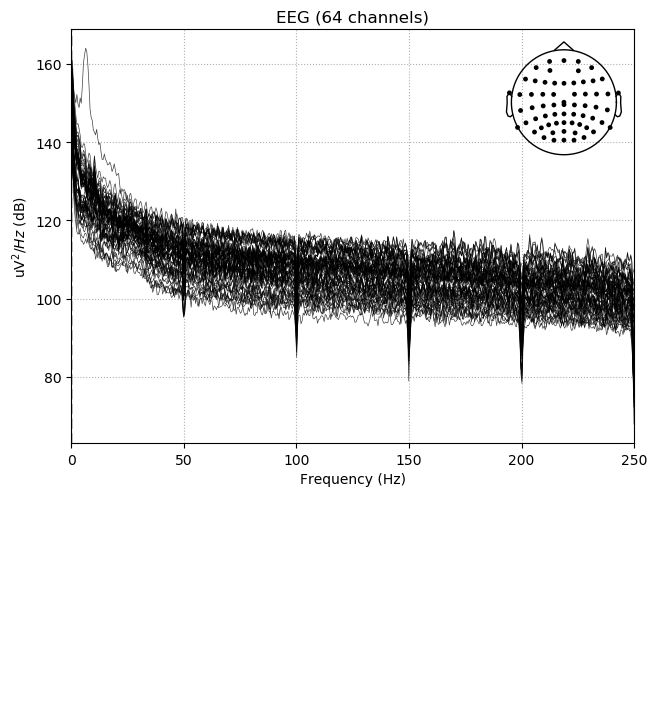

In [9]:
newraw_ec.plot_psd(tmax=np.inf, fmax=250, n_fft=2048)

In [ ]:
# some attempts at doing ICA
from mne.preprocessing import ICA
method = 'fastica'
n_components = 25
decim = 3
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

picks_eeg = mne.pick_types(newraw_ec.info, meg=False, eeg=True, eog=False,
                           stim=False, exclude='bads')
reject = dict(eeg=1e-3)
ica.fit(newraw_ec, picks=picks_eeg, decim=decim, reject=reject)
print(ica)